1. Sex (categoacal): M, F, and I (infant)
2. Length (continuous) - Longest shell measurement, mm
3. Diameter	(continuous) - perpendicular to length, mm
4. Height (continuous) - with meat in shell, mm
5. Whole weight (continuous) - whole abalone, grams
6. Shucked weight (continuous) - weight of meat, grams
7. Viscera weight (continuous) - gut weight (after bleeding), grams
8. Shell weight (continuous) - after being dried, grams
9. Rings (integer): +1.5 gives the age in years **TARGET**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, get_scorer_names
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EDA

* **train.csv** - the training dataset; `Rings` is the integer target
* **test.csv** - the test dataset; your objective is to predict the value of `Rings` for each row
* **sample_submission.csv** - a sample submission file in the correct format

Import files as `train` and `test`:

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
original = pd.read_csv('original.csv')

In [3]:
train.tail()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6
90614,90614,I,0.425,0.325,0.100,0.3455,0.1525,0.0785,0.1050,8


In [4]:
test.tail()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
60406,151021,I,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500
60407,151022,F,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050
60408,151023,I,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650
60409,151024,F,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350
60410,151025,F,0.430,0.340,0.120,0.4150,0.1525,0.0910,0.0905


In [5]:
original.tail()

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10
4176,4176,M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.4950,12


Rename columns like an original data:

In [6]:
column_names = ['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
train.columns = column_names
test.columns  = column_names[:-1]

In [7]:
train = pd.concat([train, original], axis=0, ignore_index=True).reset_index()
train.drop(['id', 'index'], axis=1, inplace=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94792 entries, 0 to 94791
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole_weight    94792 non-null  float64
 5   Shucked_weight  94792 non-null  float64
 6   Viscera_weight  94792 non-null  float64
 7   Shell_weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.5+ MB


## Distribution of features

In [9]:
data = train.copy()

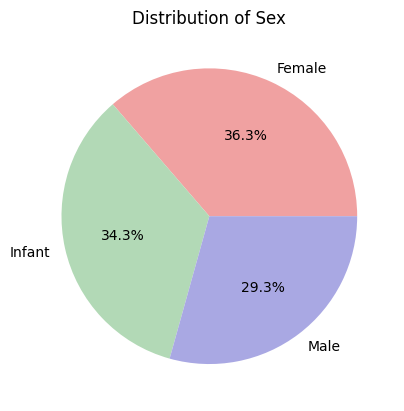

In [10]:
plt.pie(data['Sex'].value_counts(),
        autopct='%1.1f%%',
        labels=['Female', 'Infant', 'Male'],
        colors=['#f0a1a1', '#b2d9b6', '#a9a8e3'])
plt.title('Distribution of Sex')

plt.show()

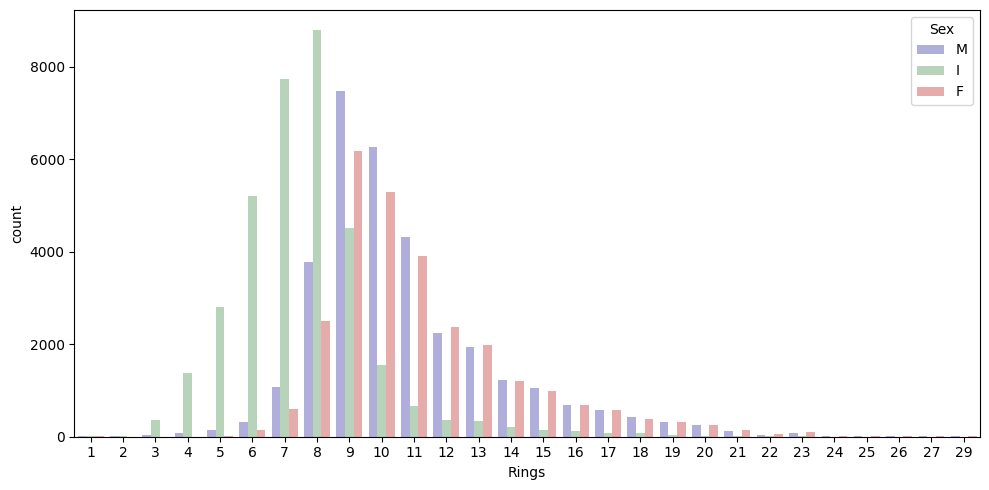

In [11]:
plt.figure(figsize=(10, 5))

sns.countplot(data=data,
              x='Rings',
              hue='Sex',
              palette=['#a9a8e3', '#b2d9b6', '#f0a1a1'])

plt.tight_layout()
plt.show()

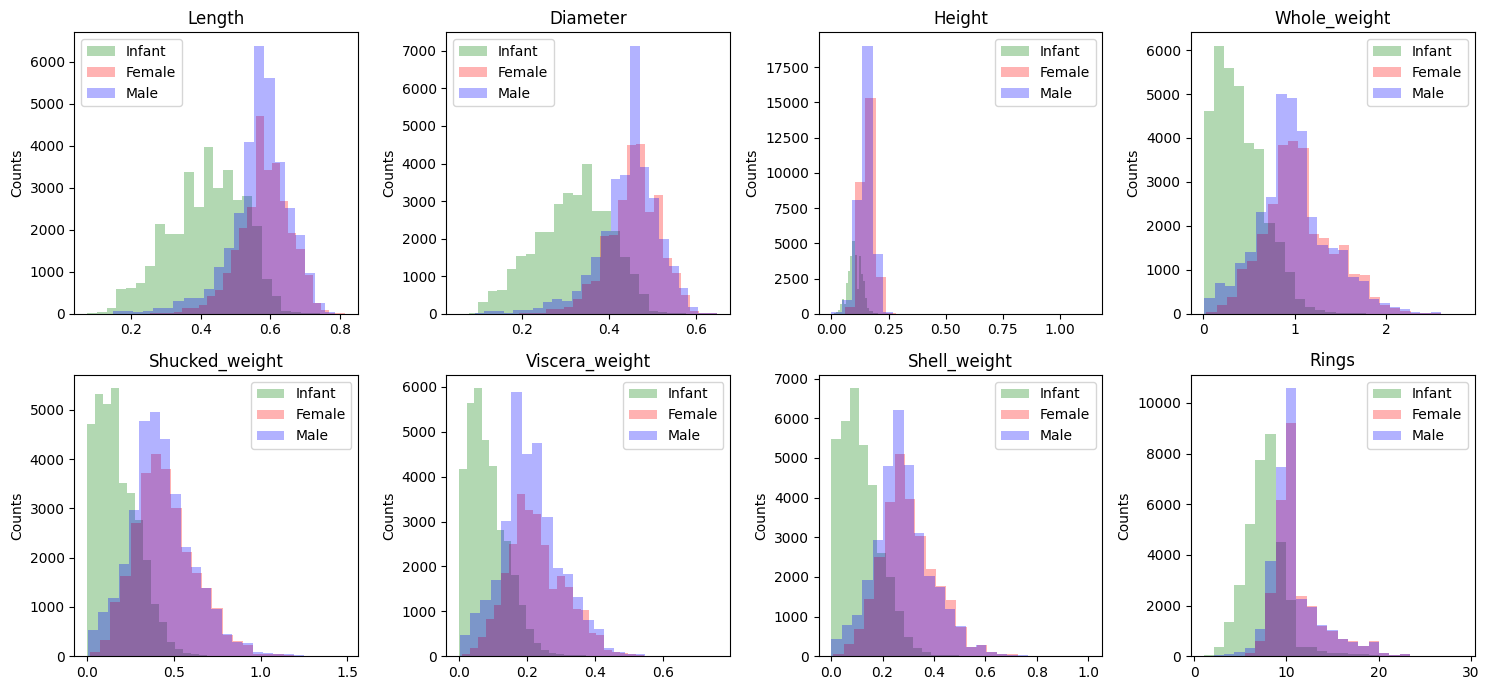

In [12]:
sex = data.columns[0]
features = data.drop(['Sex'], axis=1).columns

plt.figure(figsize=(15, 7))

for i, col in enumerate(data.columns[1:]):

    plt.subplot(2, 4, i+1).set_title(col)

    x_col = data[features[i]].values
    y_col = data[sex].values

    plt.hist(x_col[y_col == 'I'], label='Infant', color='green', alpha=0.3,  bins=25)
    plt.hist(x_col[y_col == 'F'], label='Female', color='red', alpha=0.3,  bins=25)
    plt.hist(x_col[y_col == 'M'], label='Male', color='blue', alpha=0.3,  bins=25)

    plt.ylabel('Counts')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Encode `Sex`

Encode the `Sex` feature to make all our features numerical.

In [13]:
train['Sex'] = train['Sex'].replace({'I': 1,
                                     'F': 2,
                                     'M': 3})

test['Sex'] = test['Sex'].replace({'I': 1,
                                   'F': 2,
                                   'M': 3})

## Correlation

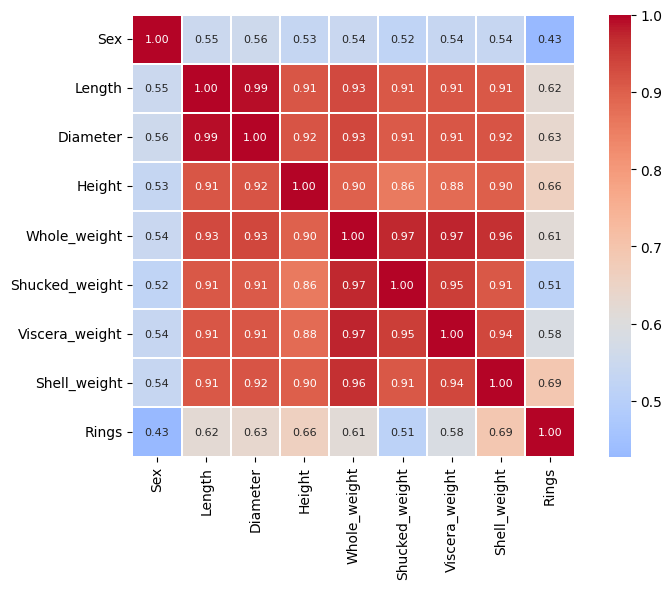

In [14]:
plt.figure(figsize=[8, 6])
sns.heatmap(train.corr(), annot=True , fmt='.2f', annot_kws={"fontsize": 8},
            linewidths=0.25, center=0.6, cmap='coolwarm', square=True)

plt.tight_layout()
plt.show()

Very high correlation between the features.

# Models

Root mean squared log error:

In [15]:
def rmsle(y_true, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return rmsle

Split train data. Log transformation for the target feature `Rings` - Root Mean Squared Logarithmic Error can't be counted when targets contain negative values.

In [16]:
y = train['Rings']
y_log = np.log(1+y)
X = train.drop('Rings', axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.30,
                                                    stratify=train['Sex'],
                                                    random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66354, 8), (28438, 8), (66354,), (28438,))

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Default model parameters

In [19]:
def model(method, X_train, X_test, y_train, y_test, random_state=RANDOM_SEED):  
    model = method
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_RMSLE = rmsle(y_true=y_train, y_pred=y_train_pred)
    test_RMSLE = rmsle(y_true=y_test, y_pred=y_test_pred)
    test_r2_score = r2_score(y_true=y_test, y_pred=y_test_pred)

    return train_RMSLE, test_RMSLE, np.round(test_r2_score, 6)

In [20]:
def report(model, name):
    report = pd.DataFrame({'Train RMSLE': model[0],
                           'Test RMSLE': model[1],
                           'Test R2': model[2]},
                           index=[name])
    return report

In [21]:
lin = report(model(LinearRegression(),
                   X_train, X_test, y_train, y_test),
                   'Linear Regression')
ridge = report(model(Ridge(),
                     X_train, X_test, y_train, y_test),
                     'Ridge Regression')
forest = report(model(RandomForestRegressor(),
                     X_train, X_test, y_train, y_test),
                     'Random Forest Regression')
bagging = report(model(BaggingRegressor(),
                       X_train, X_test, y_train, y_test),
                       'Bagging Regression')
xgb = report(model(XGBRegressor(),
                   X_train, X_test, y_train, y_test),
                   'XGBoost Regression')
lgbm = report(model(LGBMRegressor(verbose=0),
                    X_train, X_test, y_train, y_test),
                    'LightGBM Regression')
cat = report(model(CatBoostRegressor(verbose=0),
                   X_train, X_test, y_train, y_test),
                   'CatBoost Regression')

In [22]:
report_df = pd.concat([lin, ridge, forest, bagging, xgb, lgbm, cat], axis=0)
report_df

,Train RMSLE,Test RMSLE,Test R2
Linear Regression,0.049806,0.049200,0.667240
Ridge Regression,0.049806,0.049200,0.667239
Random Forest Regression,0.017691,0.045806,0.716091
Bagging Regression,0.020856,0.047807,0.690532
XGBoost Regression,0.041198,0.045048,0.724207
LightGBM Regression,0.044126,0.044750,0.727181
CatBoost Regression,0.042644,0.044591,0.730209


CatBoost Regression with default parameters shows best metrics on train data.

## CatBoost tuning

In [23]:
cat_model = CatBoostRegressor(random_seed=RANDOM_SEED, verbose=0)
cat_model.fit(X_train, y_train)

y_test_cat = cat_model.predict(X_test)

np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_cat))

0.1485622050172975

### Setup Optuna:

In [24]:
# def objective_cat(trial, random_seed_mult):
    
#     params = {'iterations': trial.suggest_int('iterations', 1000, 3000),
#               'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
#               'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#               'depth': trial.suggest_int('depth', 1, 10),
#               'border_count': trial.suggest_int('border_count', 200, 255),
#               'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 100),
#               'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
#               'task_type': 'CPU',
#               'random_seed': RANDOM_SEED * random_seed_mult,
#               'loss_function':'RMSE'}

#     cat_model = CatBoostRegressor(**params, verbose=0)
#     cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED * random_seed_mult)
#     score = cross_val_score(cat_model, X_train, y_train, cv=cv, n_jobs=-1,
#                             scoring='neg_root_mean_squared_error')
#     return -np.mean(score)

# study_params = [(0, 'minimize'),
#                 (1, 'minimize'),
#                 (2, 'minimize')]
# best_params_cat1 = {}
# best_params_cat2 = {}
# best_params_cat3 = {}

# for i, direction in study_params:
#     study_cat = optuna.create_study(direction=direction,
#                                     sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED * i,
#                                                                        n_startup_trials=20,
#                                                                        multivariate=True),
#                                     study_name=f'optuna_cat{i + 1}')
#     study_cat.optimize(lambda trial: objective_cat(trial, i), n_trials=100, n_jobs=-1)
#     best_params = study_cat.best_params
#     if i == 0:
#         best_params_cat1 = best_params
#     elif i == 1:
#         best_params_cat2 = best_params
#     elif i == 2:
#         best_params_cat3 = best_params

In [25]:
# print(f'best_params_cat1 = {best_params_cat1}')
# print(f'best_params_cat2 = {best_params_cat2}')
# print(f'best_params_cat3 = {best_params_cat3}')

In [26]:
best_params_cat1 = {'iterations': 2990,
                    'learning_rate': 0.048584273949650675,
                    'subsample': 0.693274117805803,
                    'depth': 8,
                    'border_count': 244,
                    'l2_leaf_reg': 22.537869410465802,
                    'colsample_bylevel': 0.6109035593934417}

In [27]:
best_params_cat2 = {'iterations': 2051,
                    'learning_rate': 0.03651491640406216,
                    'subsample': 0.933009278687344,
                    'depth': 7,
                    'border_count': 218,
                    'l2_leaf_reg': 3.3853780974941112,
                    'colsample_bylevel': 0.7216684743809507}

In [28]:
best_params_cat3 = {'iterations': 2759,
                    'learning_rate': 0.031936044406497624,
                    'subsample': 0.9133895908066452,
                    'depth': 7,
                    'border_count': 245,
                    'l2_leaf_reg': 2.173570372531028,
                    'colsample_bylevel': 0.8120853544334358}

### Fit:

In [29]:
cat1_model = CatBoostRegressor(**best_params_cat1, verbose=False)
cat1_model.fit(X_train, y_train)

cat2_model = CatBoostRegressor(**best_params_cat2, verbose=False)
cat2_model.fit(X_train, y_train)

cat3_model = CatBoostRegressor(**best_params_cat3, verbose=False)
cat3_model.fit(X_train, y_train)

print('Fitted')

Fitted


## LightGBM tuning

In [30]:
lgbm_model = LGBMRegressor(random_state=RANDOM_SEED, verbose=0)
lgbm_model.fit(X_train, y_train)

y_test_lgbm = lgbm_model.predict(X_test)

np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_lgbm))

0.14930427288162826

### Setup Optuna:

In [31]:
# def objective_lgbm(trial, random_seed_mult):
#     params = {'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#               'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#               'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#               'max_depth': trial.suggest_int('max_depth', -1, 16),
#               'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#               'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#               'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 100.0),
#               'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 100),
#               'random_state': RANDOM_SEED * random_seed_mult,
#               'n_jobs': -1,
#               'metric':'rmse',
#               'objective': 'regression'}

#     lgbm_model = LGBMRegressor(**params)
#     cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED * random_seed_mult)
#     score = cross_val_score(lgbm_model, X_train, y_train, cv=cv, n_jobs=-1,
#                             scoring='neg_root_mean_squared_error')
#     return -np.mean(score)

# study_params = [(0, 'minimize'),
#                 (1, 'minimize'),
#                 (2, 'minimize')]
# best_params_lgbm1 = {}
# best_params_lgbm2 = {}
# best_params_lgbm3 = {}

# for i, direction in study_params:
#     study_lgbm = optuna.create_study(direction=direction,
#                                      sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED * i,
#                                                                         n_startup_trials=20,
#                                                                         multivariate=True),
#                                      study_name=f'optuna_lgbm{i + 1}')
#     study_lgbm.optimize(lambda trial: objective_lgbm(trial, i), n_trials=100, n_jobs=-1)
#     best_params = study_lgbm.best_params
#     if i == 0:
#         best_params_lgbm1 = best_params
#     elif i == 1:
#         best_params_lgbm2 = best_params
#     elif i == 2:
#         best_params_lgbm3 = best_params

In [32]:
# print(f'best_params_lgbm1 = {best_params_lgbm1}')
# print(f'best_params_lgbm2 = {best_params_lgbm2}')
# print(f'best_params_lgbm3 = {best_params_lgbm3}')

In [33]:
best_params_lgbm1 = {'n_estimators': 2678,
                     'learning_rate': 0.09022305021868901,
                     'subsample': 0.2539522467890303,
                     'max_depth': 14,
                     'num_leaves': 8,
                     'colsample_bytree': 0.9386112629191288,
                     'reg_alpha': 1.8264448933490005,
                     'reg_lambda': 33.209764960046115}

In [34]:
best_params_lgbm2 = {'n_estimators': 1917,
                     'learning_rate': 0.03295212598163628,
                     'subsample': 0.800674115252639,
                     'max_depth': 6,
                     'num_leaves': 204,
                     'colsample_bytree': 0.581857652731719,
                     'reg_alpha': 0.3891969747400461,
                     'reg_lambda': 23.88663443803604}

In [35]:
best_params_lgbm3 = {'n_estimators': 1627,
                     'learning_rate': 0.014229199861734208,
                     'subsample': 0.29708433790119104,
                     'max_depth': 10,
                     'num_leaves': 235,
                     'colsample_bytree': 0.6520304312744272,
                     'reg_alpha': 1.3969814084577226,
                     'reg_lambda': 12.593313889017155}

### Fit:

In [36]:
lgbm1_model = LGBMRegressor(**best_params_lgbm1, verbose=-1)
lgbm1_model.fit(X_train, y_train)

lgbm2_model = LGBMRegressor(**best_params_lgbm2, verbose=-1)
lgbm2_model.fit(X_train, y_train)

lgbm3_model = LGBMRegressor(**best_params_lgbm3, verbose=-1)
lgbm3_model.fit(X_train, y_train)

print('Fitted')

Fitted


## XGB tuning

In [37]:
xgb_model = XGBRegressor(seed=RANDOM_SEED)
xgb_model.fit(X_train, y_train)

y_test_xgb = xgb_model.predict(X_test)

np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_xgb))

0.15011568858720079

### Setup Optuna:

In [38]:
# def objective_xgb(trial, random_seed_mult):
#     params = {'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#               'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
#               'gamma': trial.suggest_float('gamma', 0.0, 0.5),
#               'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#               'max_depth': trial.suggest_int('max_depth', 1, 16),
#               'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#               'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
#               'random_state': RANDOM_SEED,
#               'n_jobs': -1,
#               'eval_metric': 'rmse',
#               'objective': 'reg:squarederror'}

#     xgb_model = XGBRegressor(**params)
#     cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED * random_seed_mult)
#     score = cross_val_score(xgb_model, X_train, y_train, cv=cv, n_jobs=-1,
#                             scoring='neg_root_mean_squared_error')
#     return -np.mean(score)

# study_params = [(0, 'minimize'),
#                 (1, 'minimize'),
#                 (2, 'minimize')]
# best_params_xgb1 = {}
# best_params_xgb2 = {}
# best_params_xgb3 = {}

# for i, direction in study_params:
#     study_xgb = optuna.create_study(direction=direction,
#                                      sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED * i,
#                                                                         n_startup_trials=20,
#                                                                         multivariate=True),
#                                      study_name=f'optuna_xgb{i + 1}')
#     study_xgb.optimize(lambda trial: objective_xgb(trial, i), n_trials=100, n_jobs=-1)
#     best_params = study_xgb.best_params
#     if i == 0:
#         best_params_xgb1 = best_params
#     elif i == 1:
#         best_params_xgb2 = best_params
#     elif i == 2:
#         best_params_xgb3 = best_params

In [39]:
# print(f'best_params_xgb1 = {best_params_xgb1}')
# print(f'best_params_xgb2 = {best_params_xgb2}')
# print(f'best_params_xgb3 = {best_params_xgb3}')

In [40]:
best_params_xgb1 = {'n_estimators': 1518,
                    'learning_rate': 0.012965837987574155,
                    'gamma': 0.004388978745493273,
                    'subsample': 0.5856140222691781,
                    'max_depth': 7,
                    'colsample_bytree': 0.5950207833060395,
                    'min_child_weight': 6}

In [41]:
best_params_xgb2 = {'n_estimators': 509,
                    'learning_rate': 0.02023403324507263,
                    'gamma': 0.0486418679710911,
                    'subsample': 0.3987418218706684,
                    'max_depth': 10,
                    'colsample_bytree': 0.7276350056341108,
                    'min_child_weight': 6}

In [42]:
best_params_xgb3 = {'n_estimators': 2647,
                    'learning_rate': 0.019347214086282188,
                    'gamma': 0.07632238938534301,
                    'subsample': 0.4583849096383787,
                    'max_depth': 8,
                    'colsample_bytree': 0.8542836568740316,
                    'min_child_weight': 7}

### Fit:

In [43]:
xgb1_model = XGBRegressor(**best_params_xgb1)
xgb1_model.fit(X_train, y_train)

xgb2_model = XGBRegressor(**best_params_xgb2)
xgb2_model.fit(X_train, y_train)

xgb3_model = XGBRegressor(**best_params_xgb2)
xgb3_model.fit(X_train, y_train)

print('Fitted')

Fitted


## VotingRegressor

### Tuning ensemble weights:

In [44]:
estimators = estimators=[('LightGBM Regressor 1', lgbm1_model),
                         ('LightGBM Regressor 2', lgbm2_model),
                         ('LightGBM Regressor 3', lgbm3_model),
                         ('XGBoost Regressor 1', xgb1_model),
                         ('XGBoost Regressor 2', xgb2_model),
                         ('XGBoost Regressor 3', xgb3_model),
                         ('CatBoost Regressor 1', cat1_model),
                         ('CatBoost Regressor 2', cat2_model),
                         ('CatBoost Regressor 3', cat3_model)]

In [45]:
# def objective_voting(trial):
    
#     params = {'lgbm1_weight': trial.suggest_float('lgbm1_weight', 0.0, 10.0),
#               'lgbm2_weight': trial.suggest_float('lgbm2_weight', 0.0, 10.0),
#               'lgbm3_weight': trial.suggest_float('lgbm3_weight', 0.0, 10.0),
#               'xgb1_weight': trial.suggest_float('xgb1_weight', 0.0, 10.0),
#               'xgb2_weight': trial.suggest_float('xgb2_weight', 0.0, 10.0),
#               'xgb3_weight': trial.suggest_float('xgb3_weight', 0.0, 10.0),
#               'cat1_weight': trial.suggest_float('cat1_weight', 0.0, 10.0),
#               'cat2_weight': trial.suggest_float('cat2_weight', 0.0, 10.0),
#               'cat3_weight': trial.suggest_float('cat3_weight', 0.0, 10.0)}
    
#     cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
    
#     voting = VotingRegressor(estimators=estimators,
#                              weights=[params['lgbm1_weight'],
#                                       params['lgbm2_weight'],
#                                       params['lgbm3_weight'],
#                                       params['xgb1_weight'],
#                                       params['xgb2_weight'],
#                                       params['xgb3_weight'],
#                                       params['cat1_weight'],
#                                       params['cat2_weight'],
#                                       params['cat3_weight']])
#     score = cross_val_score(voting, X_train, y_train, cv=cv, n_jobs=-1,
#                             scoring='neg_root_mean_squared_error')
#     return -np.mean(score)

# study_voting = optuna.create_study(direction='minimize',
#                                    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED,
#                                                                       n_startup_trials=20,
#                                                                       multivariate=True),
#                                    study_name='optuna_voting')
# study_voting.optimize(objective_voting, n_trials=100, n_jobs=-1)
# best_params_voting = study_voting.best_params

In [46]:
# best_params_voting

In [47]:
best_params_voting = {'lgbm1_weight': 8.534309199664701,
                      'lgbm2_weight': 6.651509086669025,
                      'lgbm3_weight': 7.022097542064461,
                      'xgb1_weight': 0.6293183086161971,
                      'xgb2_weight': 1.0666908926330385,
                      'xgb3_weight': 0.8658434393843959,
                      'cat1_weight': 0.30104806155789965,
                      'cat2_weight': 3.0320101228538925,
                      'cat3_weight': 1.6978086423033254}


### Fit:

In [48]:
weights = list(best_params_voting.values())

voting = VotingRegressor(estimators=estimators,
                         weights=weights,
                         n_jobs=-1)

voting.fit(X_train, y_train)

VotingRegressor(estimators=[('LightGBM Regressor 1',
                             LGBMRegressor(colsample_bytree=0.9386112629191288,
                                           learning_rate=0.09022305021868901,
                                           max_depth=14, n_estimators=2678,
                                           num_leaves=8,
                                           reg_alpha=1.8264448933490005,
                                           reg_lambda=33.209764960046115,
                                           subsample=0.2539522467890303,
                                           verbose=-1)),
                            ('LightGBM Regressor 2',
                             LGBMRegressor(colsample_bytree=0.581857652731719,...
                            ('CatBoost Regressor 2',
                             <catboost.core.CatBoostRegressor object at 0x000001F1458FF830>),
                            ('CatBoost Regressor 3',
                             <catboost.core.CatBoostRegressor object at 0x000001F1458FC320>)],
                n_jobs=-1,
                weights=[8.534309199664701, 6.651509086669025,
                         7.022097542064461, 0.6293183086161971,
                         1.0666908926330385, 0.8658434393843959,
                         0.30104806155789965, 3.0320101228538925,
                         1.6978086423033254])

## Predict

In [49]:
data = test.drop(['id'], axis=1)
test_scaled = scaler.transform(data)
y_pred = np.expm1(voting.predict(test_scaled))

In [50]:
predictions_df = pd.DataFrame({'id': test['id'], 'Rings': y_pred})
predictions_df.head()

,id,Rings
0,90615,9.537175
1,90616,9.777723
2,90617,9.931527
3,90618,10.515447
4,90619,7.587810


In [51]:
predictions_df.to_csv('submission.csv', index=False)